# ***Semantic Segmentation using U-Net with vgg16 as Background with Keras and TensorFlow***

# **Installing Librarires**

In [1]:
!pip install segmentation-models

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 50 kB 7.5 MB/s 


In [2]:
!pip install keras==2.9.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
!pip install livelossplot

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.6 MB 34.1 MB/s 


In [4]:
%matplotlib inline

In [5]:
!pip install tensorflow==2.7.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 665.5 MB 24 kB/s 
     |████████████████████████████████| 463 kB 26.5 MB/s 
     |████████████████████████████████| 1.3 MB 52.6 MB/s 
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.9.0
    Uninstalling tensorflow-estimator-2.9.0:
      Successfully uninstalled tensorflow-estimator-2.9.0
  Attempting uninstall: keras
    Found existing installation: keras 2.9.0
    Uninstalling keras-2.9.0:
      Successfully uninstalled keras-2.9.0
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.9.2
    Uninstalling tensorflow-2.9.2:
      Successfully uninstalled tensorflow-2.9.2


# **Importing Libraries**

In [6]:
import segmentation_models as sm
import glob
import cv2
import os
import numpy as np
from matplotlib import pyplot as plt
import keras 
from tensorflow.keras.utils import normalize
from keras.metrics import MeanIoU
from skimage import io, util
from scipy import io as sio
import numpy as np
import matplotlib.pyplot as plt
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from skimage import data, io
from matplotlib import pyplot as plt
from keras import backend as K
import os
import random
import tensorflow as tf
from keras import backend as K
from keras.models import Model, load_model
from keras.layers import Input, BatchNormalization, Activation, Dense, Dropout
from keras.layers.core import Lambda, RepeatVector, Reshape
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D, GlobalMaxPool2D
from keras.layers import Concatenate
from keras.layers import Input
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, BatchNormalization, Activation, Dense, Dropout
from tensorflow.keras.layers import Lambda, RepeatVector, Reshape, Add, Concatenate, ZeroPadding2D
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, DepthwiseConv2D
from tensorflow.keras.layers import MaxPooling2D, GlobalMaxPool2D, GlobalAveragePooling2D
from tensorflow.keras.layers import concatenate, add
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from tensorflow.python.keras.activations import relu


Segmentation Models: using `keras` framework.


# **Loading the CitySpace Dataset**

In [7]:
# from google.colab import drive
# drive.mount('/content/drive')
!unzip '/content/A3_Dataset.zip' 

Archive:  /content/A3_Dataset.zip
   creating: A3_Dataset/
   creating: A3_Dataset/dataset1/
   creating: A3_Dataset/dataset1/annotations_prepped_test/
  inflating: A3_Dataset/dataset1/annotations_prepped_test/0016E5_07959.png  
  inflating: A3_Dataset/dataset1/annotations_prepped_test/0016E5_07961.png  
  inflating: A3_Dataset/dataset1/annotations_prepped_test/0016E5_07963.png  
  inflating: A3_Dataset/dataset1/annotations_prepped_test/0016E5_07965.png  
  inflating: A3_Dataset/dataset1/annotations_prepped_test/0016E5_07967.png  
  inflating: A3_Dataset/dataset1/annotations_prepped_test/0016E5_07969.png  
  inflating: A3_Dataset/dataset1/annotations_prepped_test/0016E5_07971.png  
  inflating: A3_Dataset/dataset1/annotations_prepped_test/0016E5_07973.png  
  inflating: A3_Dataset/dataset1/annotations_prepped_test/0016E5_07975.png  
  inflating: A3_Dataset/dataset1/annotations_prepped_test/0016E5_07977.png  
  inflating: A3_Dataset/dataset1/annotations_prepped_test/0016E5_07979.png  
 

In [8]:
#Processing the Training Images
#Resizing images
SIZE_X = 128 
SIZE_Y = 128

#Capture training image info as a list
train_images = []
for directory_path in glob.glob("/content/A3_Dataset/dataset1/images_prepped_train"):
    for img_path in glob.glob(os.path.join(directory_path, "*.png")):
        img = cv2.imread(img_path, 1)       
        img = cv2.resize(img, (SIZE_Y, SIZE_X))
        train_images.append(img)
       
#Convert list to array    
train_images = np.array(train_images)

#Capture mask/label info as a list
train_masks = [] 
for directory_path in glob.glob("/content/A3_Dataset/dataset1/annotations_prepped_train"):
    for mask_path in glob.glob(os.path.join(directory_path, "*.png")):
        mask = cv2.imread(mask_path, 0)       
        mask = cv2.resize(mask, (SIZE_Y, SIZE_X)) 
        train_masks.append(mask)
        
#Convert list to array      
train_masks = np.array(train_masks)


In [9]:
train_masks_input = np.expand_dims(train_masks, axis=3)
X_train = train_images
y_train = train_masks_input

In [10]:
#processing the test images
#Resizing images
SIZE_X = 128 
SIZE_Y = 128

#Capture testing image info as a list
test_images = []

for directory_path in glob.glob("/content/A3_Dataset/dataset1/images_prepped_test"):
    for img_path in glob.glob(os.path.join(directory_path, "*.png")):
        img = cv2.imread(img_path, 1)       
        img = cv2.resize(img, (SIZE_Y, SIZE_X))
        test_images.append(img)
       
#Convert list to array       
test_images = np.array(test_images)

#Capture mask/label info as a list
test_masks = [] 
for directory_path in glob.glob("/content/A3_Dataset/dataset1/annotations_prepped_test"):
    for mask_path in glob.glob(os.path.join(directory_path, "*.png")):
        mask = cv2.imread(mask_path, 0)       
        mask = cv2.resize(mask, (SIZE_Y, SIZE_X))
        test_masks.append(mask)
        
#Convert list to array        
test_masks = np.array(test_masks)

In [11]:
test_masks_input = np.expand_dims(test_masks, axis=3)
X_test = test_images
y_test = test_masks_input

In [12]:
print("Class values in the dataset are ... ", np.unique(y_train))

Class values in the dataset are ...  [ 0  1  2  3  4  5  6  7  8  9 10 11]


In [13]:
test_masks_input.shape

(101, 128, 128, 1)

# **Convert the Masks to One-Hot Encoded Vectors**

In [14]:
n_classes=12 #Number of classes for segmentation
from tensorflow.keras.utils import to_categorical
train_masks_cat = to_categorical(y_train, num_classes=n_classes)
y_train_cat = train_masks_cat.reshape((y_train.shape[0], y_train.shape[1], y_train.shape[2], n_classes))
test_masks_cat = to_categorical(y_test, num_classes=n_classes)
y_test_cat = test_masks_cat.reshape((y_test.shape[0], y_test.shape[1], y_test.shape[2], n_classes))


In [15]:
print(y_train_cat.shape)
print(y_test_cat.shape)

(367, 128, 128, 12)
(101, 128, 128, 12)


In [16]:
y_test_cat[0]

array([[[0., 1., 0., ..., 0., 0., 0.],
        [0., 1., 0., ..., 0., 0., 0.],
        [0., 1., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 1., 0., ..., 0., 0., 0.],
        [0., 1., 0., ..., 0., 0., 0.],
        [0., 1., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 1., 0., ..., 0., 0., 0.],
        [0., 1., 0., ..., 0., 0., 0.],
        [0., 1., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       ...,

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0.

# **Setting the Model Parameters**

In [17]:
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
activation='softmax'
metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]



In [18]:
#setting the framework
sm.set_framework('tf.keras')

# **U-net with vgg16 as Background**

**Transfer Learning**
The resnet34 backbone have pre-trained weights that have been traiend on Imagenet for faster and better convergence

In [19]:
BACKBONE1 = 'vgg16'
preprocess_input1 = sm.get_preprocessing(BACKBONE1)

# preprocess input
X_train = preprocess_input1(X_train)
X_test = preprocess_input1(X_test)

# define model(Transfer Learning)
model1 = sm.Unet(BACKBONE1, encoder_weights='imagenet', classes=n_classes, activation=activation)

# compile keras model with defined optimozer, loss and metrics
model1.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001,amsgrad=True), loss=tf.keras.losses.CategoricalCrossentropy(), metrics=["accuracy",metrics])

#Check the model summary
print(model1.summary())

58900480/58889256 [==============================] - 0s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 block1_conv1 (Conv2D)          (None, None, None,   1792        ['input_1[0][0]']                
                                64)                                                               
                                                                                                  
 block1_conv2 (Conv2D)          (None, None, None,   36928       ['block1_conv1[0][0]']           
                             

In [20]:
!pip install h5py==2.10.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.9 MB 29.0 MB/s 
  Attempting uninstall: h5py
    Found existing installation: h5py 3.1.0
    Uninstalling h5py-3.1.0:
      Successfully uninstalled h5py-3.1.0


# **Training the model**

In [21]:
callbacks = [
    ReduceLROnPlateau(factor=0.1, patience=3, min_lr=0.00001, verbose=1)
    ]
history1=model1.fit(X_train, 
          y_train_cat,
          batch_size=16, 
          epochs=30,
           verbose=1,
         callbacks = callbacks,
          validation_data=(X_test, y_test_cat))

model1.save('vgg16_backbone_unet.h5')

Epoch 1/30
23/23 [==============================] - 27s 401ms/step - loss: 1.5721 - accuracy: 0.5393 - iou_score: 0.0934 - f1-score: 0.1120 - val_loss: 5.0783 - val_accuracy: 0.3313 - val_iou_score: 0.0917 - val_f1-score: 0.1116 - lr: 0.0010
Epoch 2/30
23/23 [==============================] - 3s 137ms/step - loss: 1.0094 - accuracy: 0.7079 - iou_score: 0.1780 - f1-score: 0.2060 - val_loss: 1.4675 - val_accuracy: 0.5846 - val_iou_score: 0.1335 - val_f1-score: 0.1635 - lr: 0.0010
Epoch 3/30
23/23 [==============================] - 3s 137ms/step - loss: 0.8359 - accuracy: 0.7601 - iou_score: 0.2354 - f1-score: 0.2817 - val_loss: 1.2264 - val_accuracy: 0.6274 - val_iou_score: 0.1751 - val_f1-score: 0.2062 - lr: 0.0010
Epoch 4/30
23/23 [==============================] - 3s 137ms/step - loss: 0.7418 - accuracy: 0.7883 - iou_score: 0.2920 - f1-score: 0.3533 - val_loss: 1.0184 - val_accuracy: 0.7082 - val_iou_score: 0.2519 - val_f1-score: 0.3101 - lr: 0.0010
Epoch 5/30
23/23 [=================

# **Quantitative Performance Measures**

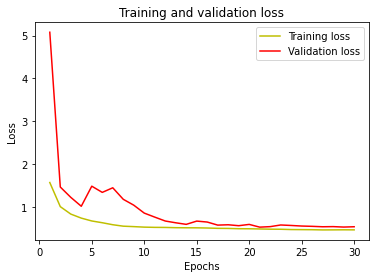

In [22]:
#plotting the cross entropy loss
loss = history1.history['loss']
val_loss = history1.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


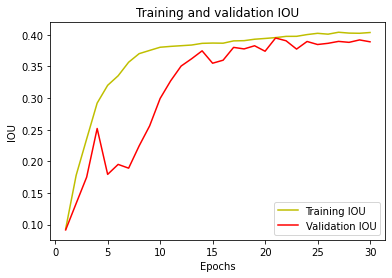

In [24]:
#plotting the iou score
iou_score = history1.history['iou_score']
val_iou_score = history1.history['val_iou_score']
plt.plot(epochs, iou_score, 'y', label='Training IOU')
plt.plot(epochs, val_iou_score, 'r', label='Validation IOU')
plt.title('Training and validation IOU')
plt.xlabel('Epochs')
plt.ylabel('IOU')
plt.legend()
plt.show()



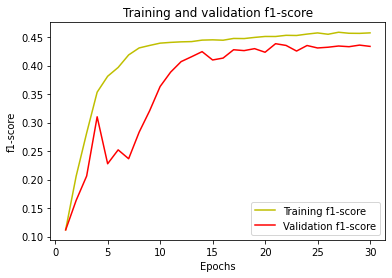

In [25]:
#plotting the f1 score
f1_score = history1.history['f1-score']
val_f1_score = history1.history['val_f1-score']
plt.plot(epochs, f1_score, 'y', label='Training f1-score')
plt.plot(epochs, val_f1_score, 'r', label='Validation f1-score')
plt.title('Training and validation f1-score')
plt.xlabel('Epochs')
plt.ylabel('f1-score')
plt.legend()
plt.show()


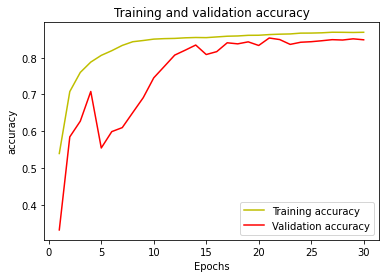

In [26]:
#plotting the accuracy
accuracy = history1.history['accuracy']
val_accuracy = history1.history['val_accuracy']
plt.plot(epochs, accuracy, 'y', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()


# **Loading the Trained Model and Making Predictions**

In [28]:
from keras.models import load_model
model1_load = load_model('/content/vgg16_backbone_unet.h5', compile=False)

In [29]:
y_pred1=model1_load.predict(X_test)
y_pred1_argmax=np.argmax(y_pred1, axis=3)

In [30]:
print(y_pred1.shape)
print(y_pred1_argmax.shape)

(101, 128, 128, 12)
(101, 128, 128)


# **Qualitative Results**

Visualizing the Original Image, Ground Truth in the form of segmentation mask and Ground Truth image Super-imposed on original image 

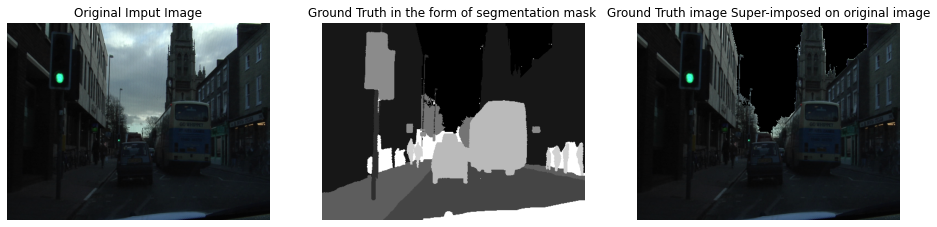

In [31]:
#for training Images
import matplotlib.pyplot as plt
input_img = plt.imread('/content/A3_Dataset/dataset1/images_prepped_train/0001TP_006750.png')
mask_img  = plt.imread('/content/A3_Dataset/dataset1/annotations_prepped_train/0001TP_006750.png')

# select only masked area below
masked = input_img.copy()
masked[mask_img == 0 ] = 0

fig, axes = plt.subplots(1, 3, figsize=(16, 12))
ax = axes.flatten()

ax[0].imshow(input_img, cmap="gray")
ax[0].set_axis_off()
ax[0].set_title("Original Imput Image", fontsize=12)

ax[1].imshow(mask_img, cmap="gray")
ax[1].set_axis_off()
ax[1].set_title("Ground Truth in the form of segmentation mask ", fontsize=12)

ax[2].imshow(masked, cmap="gray")
ax[2].set_axis_off()
ax[2].set_title("Ground Truth image Super-imposed on original image", fontsize=12)

plt.show()

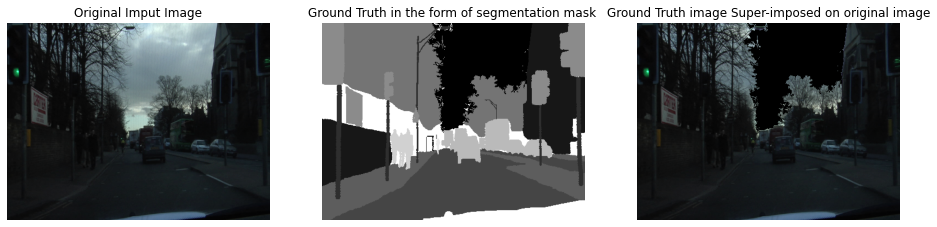

In [32]:
import matplotlib.pyplot as plt
input_img1 = plt.imread('/content/A3_Dataset/dataset1/images_prepped_train/0001TP_007110.png')
mask_img1  = plt.imread('/content/A3_Dataset/dataset1/annotations_prepped_train/0001TP_007110.png')

# select only masked area below
masked1 = input_img1.copy()
masked1[mask_img1 == 0 ] = 0

fig, axes = plt.subplots(1, 3, figsize=(16, 12))
ax = axes.flatten()

ax[0].imshow(input_img1, cmap="gray")
ax[0].set_axis_off()
ax[0].set_title("Original Imput Image", fontsize=12)

ax[1].imshow(mask_img1, cmap="gray")
ax[1].set_axis_off()
ax[1].set_title("Ground Truth in the form of segmentation mask ", fontsize=12)

ax[2].imshow(masked1, cmap="gray")
ax[2].set_axis_off()
ax[2].set_title("Ground Truth image Super-imposed on original image", fontsize=12)

plt.show()

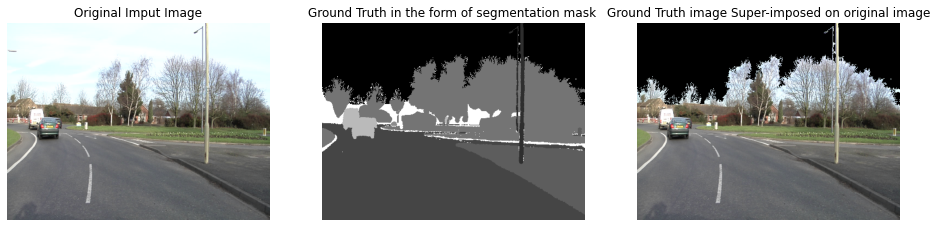

In [33]:
import matplotlib.pyplot as plt
input_img1 = plt.imread('/content/A3_Dataset/dataset1/images_prepped_train/0006R0_f00990.png')
mask_img1  = plt.imread('/content/A3_Dataset/dataset1/annotations_prepped_train/0006R0_f00990.png')

# select only masked area below
masked1 = input_img1.copy()
masked1[mask_img1 == 0 ] = 0

fig, axes = plt.subplots(1, 3, figsize=(16, 12))
ax = axes.flatten()

ax[0].imshow(input_img1, cmap="gray")
ax[0].set_axis_off()
ax[0].set_title("Original Imput Image", fontsize=12)

ax[1].imshow(mask_img1, cmap="gray")
ax[1].set_axis_off()
ax[1].set_title("Ground Truth in the form of segmentation mask ", fontsize=12)

ax[2].imshow(masked1, cmap="gray")
ax[2].set_axis_off()
ax[2].set_title("Ground Truth image Super-imposed on original image", fontsize=12)

plt.show()

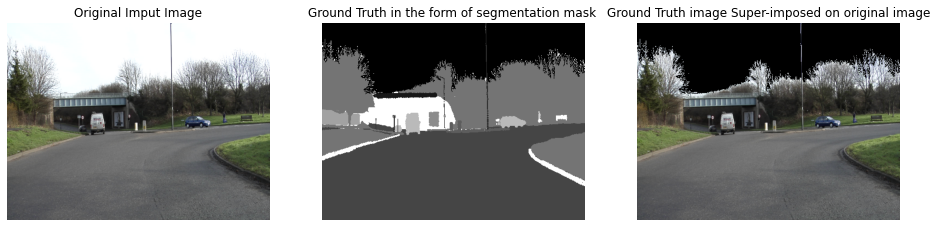

In [34]:
import matplotlib.pyplot as plt
input_img1 = plt.imread('/content/A3_Dataset/dataset1/images_prepped_train/0006R0_f01350.png')
mask_img1  = plt.imread('/content/A3_Dataset/dataset1/annotations_prepped_train/0006R0_f01350.png')

# select only masked area below
masked1 = input_img1.copy()
masked1[mask_img1 == 0 ] = 0

fig, axes = plt.subplots(1, 3, figsize=(16, 12))
ax = axes.flatten()

ax[0].imshow(input_img1, cmap="gray")
ax[0].set_axis_off()
ax[0].set_title("Original Imput Image", fontsize=12)

ax[1].imshow(mask_img1, cmap="gray")
ax[1].set_axis_off()
ax[1].set_title("Ground Truth in the form of segmentation mask ", fontsize=12)

ax[2].imshow(masked1, cmap="gray")
ax[2].set_axis_off()
ax[2].set_title("Ground Truth image Super-imposed on original image", fontsize=12)

plt.show()

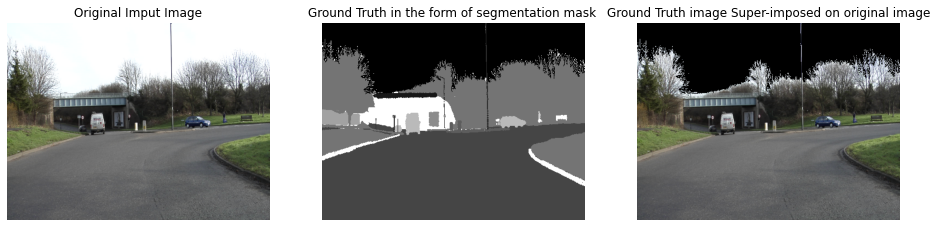

In [35]:
import matplotlib.pyplot as plt
input_img1 = plt.imread('/content/A3_Dataset/dataset1/images_prepped_train/0006R0_f01350.png')
mask_img1  = plt.imread('/content/A3_Dataset/dataset1/annotations_prepped_train/0006R0_f01350.png')

# select only masked area below
masked1 = input_img1.copy()
masked1[mask_img1 == 0 ] = 0

fig, axes = plt.subplots(1, 3, figsize=(16, 12))
ax = axes.flatten()

ax[0].imshow(input_img1, cmap="gray")
ax[0].set_axis_off()
ax[0].set_title("Original Imput Image", fontsize=12)

ax[1].imshow(mask_img1, cmap="gray")
ax[1].set_axis_off()
ax[1].set_title("Ground Truth in the form of segmentation mask ", fontsize=12)

ax[2].imshow(masked1, cmap="gray")
ax[2].set_axis_off()
ax[2].set_title("Ground Truth image Super-imposed on original image", fontsize=12)

plt.show()

# **Qualitative Performance for Testing Images**


**Incorrectly Classified Images**

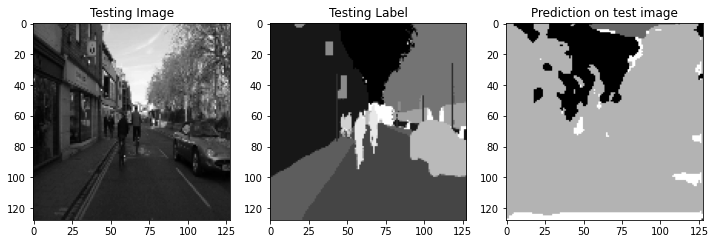

In [36]:
test_img = X_test[70]
ground_truth=y_test[70]
test_img_input=np.expand_dims(test_img, 0)
test_img_input1 = preprocess_input1(test_img_input)
test_pred1 = model1.predict(test_img_input1)
test_prediction1 = np.argmax(test_pred1, axis=3)[0,:,:]


plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,0], cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:,0], cmap='gray')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(test_prediction1, cmap='gray')
plt.show()


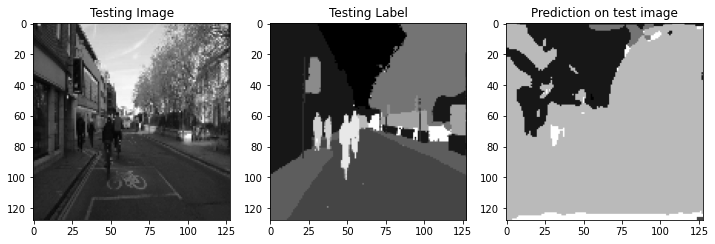

In [37]:
test_img = X_test[20]
ground_truth=y_test[20]
test_img_input=np.expand_dims(test_img, 0)
test_img_input1 = preprocess_input1(test_img_input)
test_pred1 = model1.predict(test_img_input1)
test_prediction1 = np.argmax(test_pred1, axis=3)[0,:,:]


plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,0], cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:,0], cmap='gray')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(test_prediction1, cmap='gray')
plt.show()

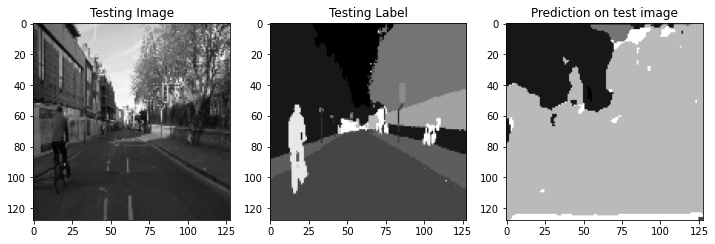

In [38]:
test_img = X_test[65]
ground_truth=y_test[65]
test_img_input=np.expand_dims(test_img, 0)
test_img_input1 = preprocess_input1(test_img_input)
test_pred1 = model1.predict(test_img_input1)
test_prediction1 = np.argmax(test_pred1, axis=3)[0,:,:]


plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,0], cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:,0], cmap='gray')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(test_prediction1, cmap='gray')
plt.show()

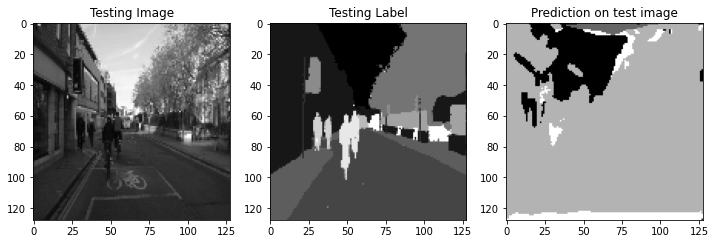

In [41]:
test_img = X_test[20]
ground_truth=y_test[20]
test_img_input=np.expand_dims(test_img, 0)
test_img_input1 = preprocess_input1(test_img_input)
test_pred1 = model1.predict(test_img_input1)
test_prediction1 = np.argmax(test_pred1, axis=3)[0,:,:]


plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,0], cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:,0], cmap='gray')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(test_prediction1, cmap='gray')
plt.show()